# CMPE 255 Project Submission 
# By Utsav Jain (012168975)
# Predicting Inpatient care requirement

In [49]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from numpy.linalg import norm
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
data = pd.read_csv('C:\\Users\\utsav\\Google Drive\\SJSU Sem2\\CMPE 255\\Project\\diabetic_data.csv')
print(data.shape)

(101766, 50)


# The Knowledge Discovery process
The usual Knowledge Discovery process consists of the following steps:
1. Selection (Business Understanding)
    * We are using the [Diabetes 130-US hospitals for years 1999-2008 Data-Set](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008# "Diabetes 130-US hospitals for years 1999-2008 Data Set") for our discovery. 
2. Preprocessing (Feature Reduction)
    *The folling feature reduction methods have been used with corresponding parameters
        i. SelectBestK
            - fclassif
            - chi2
        ii. SelectFromModel
            - L1-based
            - Tree Based
3. Modeling (Data Mining)
    * This notebook explores the KNN classification algorithm in order to predict a patient's hospital admission requirement.
    * Different KNN models have been built by changing the following parameters.
        - The k value
        - Algorithm used to compute nearest neighbour (To compare time taken)
        - 
4. Evaluation (Validation)
    * The model was trained on 80 percent of the data and then tested on 20 percent of the data.
5. Deployment (Utilization)
    * A nodeJS Front-end application was used to deploy the application
    * Binder libraries were used to call the python code from the nodeJS application


Getting familiar with data. The UCI Diabetes 130-US hospitals for years 1999-2008 Data-Set has the following attributes.

In [50]:
print(data.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


# To understand the dataset, we find the count of all the unique values in each column.

In [51]:
i = 0;
for cl in data.columns:
    if (i>1):
        print(cl)
        print(Counter(data[cl]))
        print("-------------------------------------------------------------------")
    else : i+=1

race
Counter({'Caucasian': 76099, 'AfricanAmerican': 19210, '?': 2273, 'Hispanic': 2037, 'Other': 1506, 'Asian': 641})
-------------------------------------------------------------------
gender
Counter({'Female': 54708, 'Male': 47055, 'Unknown/Invalid': 3})
-------------------------------------------------------------------
age
Counter({'[70-80)': 26068, '[60-70)': 22483, '[50-60)': 17256, '[80-90)': 17197, '[40-50)': 9685, '[30-40)': 3775, '[90-100)': 2793, '[20-30)': 1657, '[10-20)': 691, '[0-10)': 161})
-------------------------------------------------------------------
weight
Counter({'?': 98569, '[75-100)': 1336, '[50-75)': 897, '[100-125)': 625, '[125-150)': 145, '[25-50)': 97, '[0-25)': 48, '[150-175)': 35, '[175-200)': 11, '>200': 3})
-------------------------------------------------------------------
admission_type_id
Counter({1: 53990, 3: 18869, 2: 18480, 6: 5291, 5: 4785, 8: 320, 7: 21, 4: 10})
-------------------------------------------------------------------
discharge_dis

# Data Encoding
The data in the data frame consists of string. In order to build models we need to encode our data into integers. The following does that and prints 10 rows from the dataframe after encoding.

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_data = data.apply(le.fit_transform)
print(new_data[10:20])
print(new_data.shape)

    encounter_id  patient_nbr  race  gender  age  weight  admission_type_id  \
10             3        55289     1       0    4       1                  0   
11             5        47900     1       1    6       1                  1   
12             6        51918     3       0    4       1                  0   
13             7        47967     3       1    8       1                  0   
14             9        36135     1       0    6       1                  2   
15            12        52793     1       1    6       1                  0   
16            13        57359     1       1    5       1                  0   
17            14        66152     3       0    5       1                  0   
18            15        65585     1       1    7       1                  0   
19            16        45291     0       1    7       1                  2   

    discharge_disposition_id  admission_source_id  time_in_hospital  \
10                         0                    6          

# Seperating Labels
Now, we seperate the data into input and labels.
The readmitted column will be out label.

In [53]:
x = new_data.iloc[:,0:48]
y = new_data.iloc[:,49:] 
print(y.columns)
print(y.shape)

Index(['readmitted'], dtype='object')
(101766, 1)


### Training/Test set split
To avoid overfitting, we use different portions of out dataset for training and testin our model.
Here, we are splitting the data 80-20, i.e. using 80% data for training and 20% for testing.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y['readmitted'], test_size=0.2, random_state=42)
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# Start to build models

Finding the best algorithm for computing the nearest neighbour. The candidates are as follow:
    * Ball Tree
    * KD Tree
    * Brute Force

The hospitializing requirements would be predicted using knn with k ranging from 0 to 100 ro find the best k. 
The time required to build a model for each k by each algorithm will be recorded and the result be used for futher investigation.

# Knn using Ball tree algorithm for computing nearest neighbour

In [55]:
#Knn without preprocessing
import time
time_taken_Knn_with_ball_tree = []
f1_score_Knn_with_ball_tree = []
for i in range(1,100):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1, algorithm = 'ball_tree')
    neigh.fit(X_train, y_train)
    predicted = neigh.predict(X_test)
    f1_score_Knn_with_ball_tree.append(metrics.f1_score(y_test, predicted, average='weighted'))
    elapsed_time = time.time() - start_time
    time_taken_Knn_with_ball_tree.append(elapsed_time)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### We plot graphs to visualize results 

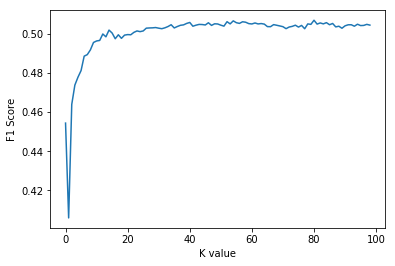

Best F1 Score is 0.506979555373
Best k is 81


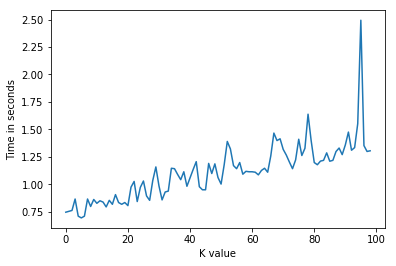

Min Time 0.6929209232330322
Max Time 2.494389533996582
Avg Time 1.108628020142064


In [56]:
import matplotlib.pyplot as plt
plt.plot(f1_score_Knn_with_ball_tree)
plt.ylabel('F1 Score')
plt.xlabel('K value')

plt.show()
best_f1 = max(f1_score_Knn_with_ball_tree)
print("Best F1 Score is " + str(best_f1))
print("Best k is "+ str(f1_score_Knn_with_ball_tree.index(best_f1)+1))

import matplotlib.pyplot as plt
plt.plot(time_taken_Knn_with_ball_tree)
plt.ylabel('Time in seconds')
plt.xlabel('K value')
plt.show()
print("Min Time " + str(min(time_taken_Knn_with_ball_tree)))
print("Max Time " + str(max(time_taken_Knn_with_ball_tree)))
print("Avg Time " + str(sum(time_taken_Knn_with_ball_tree)
                        /float(len(time_taken_Knn_with_ball_tree))))

# Knn using KD Tree algorithm for computing nearest neighbour

In [57]:
#Knn using KD Tree
import time
time_taken_Knn_with_KD_tree = []
f1_score_Knn_with_KD_tree = []
for i in range(1,100):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1, algorithm = 'kd_tree')
    neigh.fit(X_train, y_train)
    predicted = neigh.predict(X_test)
    f1_score_Knn_with_KD_tree.append(metrics.f1_score(y_test, predicted, average='weighted'))
    elapsed_time = time.time() - start_time
    time_taken_Knn_with_KD_tree.append(elapsed_time)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


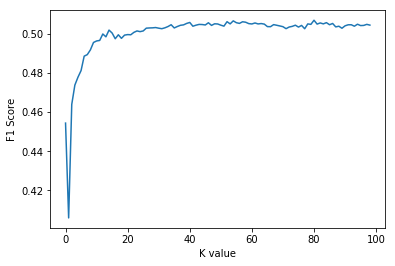

Best F1 Score is 0.506979555373
Best k is 81


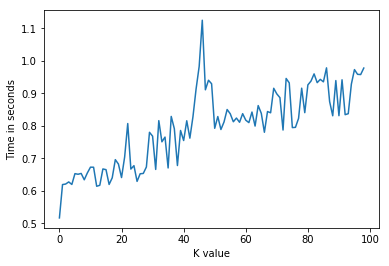

Min Time 0.5163986682891846
Max Time 1.1252756118774414
Avg Time 0.796248941710501


In [58]:
import matplotlib.pyplot as plt
plt.plot(f1_score_Knn_with_KD_tree)
plt.ylabel('F1 Score')
plt.xlabel('K value')

plt.show()
best_f1 = max(f1_score_Knn_with_KD_tree)
print("Best F1 Score is " + str(best_f1))
print("Best k is "+ str(f1_score_Knn_with_KD_tree.index(best_f1)+1))

import matplotlib.pyplot as plt
plt.plot(time_taken_Knn_with_KD_tree)
plt.ylabel('Time in seconds')
plt.xlabel('K value')
plt.show()
print("Min Time " + str(min(time_taken_Knn_with_KD_tree)))
print("Max Time " + str(max(time_taken_Knn_with_KD_tree)))
print("Avg Time " + str(sum(time_taken_Knn_with_KD_tree)/float(len(time_taken_Knn_with_KD_tree))))

## Result 1 : Performance comparision of  nearest neighbour computing algorithms

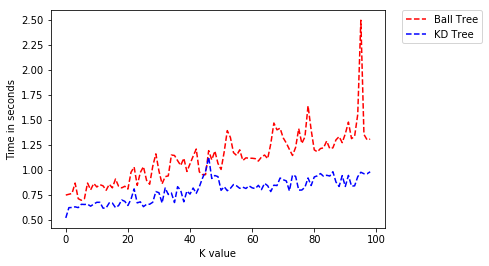

In [151]:
# We plot the graphs of time taken to build a model for each k using each algorithm
plt.xlabel('K value')
plt.ylabel('Time in seconds')
plt.plot(time_taken_Knn_with_ball_tree,'r--', label = "Ball Tree")
plt.plot(time_taken_Knn_with_KD_tree,'b--', label = "KD Tree")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Clearly 81 is the best K for the dataset without any Dimentionality Reduction
### For 81, KD is more efiicient and taked less time to compute
### Thus, I use k = 81 and KD Tree for further investigation 

# Dimentionality Reduction (D.R.)
### Also known as feature reduction, it is a preprocessing step to further improve the performance of the model building process.
### D.R. may also improve the prediction correctness.

#### Here, we use four feature reduction techniques with a combination of parameter values and compare the results to determine the best set of parameters.
#### The four methods are :
1. SelectKBest with f_classify
2. SelectKBest with chi2
3. SelectFromModel with L1 Penalty
4. SelectFromModel with tree based classifier

The following will build models by selecting a subset of features and then well compare the correctness of models computed using each of the above mentioned DR method.

# Feature Reduction using F_classif

The f_classif method computes the ANOVA F-value and returns the importance of each column. We, need to specify how many most significant columns we wish to take. So, I run a loop to iteratively build a model for all values for k (number of columns). 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [39 40] are constant.
  UserWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [29 37 39 40 44 45 46] are constant.
  UserWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


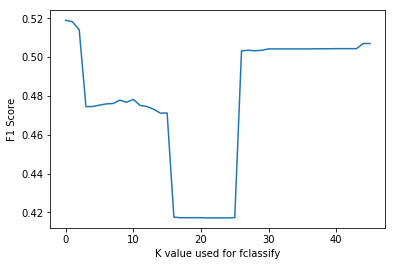

Best F1 Score is 0.518959525499
Best k (number of features ) is 1


In [61]:
# Using Select k best with f_classify
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import time
time_taken_Knn_with_fclassify = []
f1_score_Knn_with_fcassify = []
for i in range(1,47):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=81, n_jobs=-1)
    X_train_with_dr = SelectKBest(f_classif, k = i).fit_transform(X_train, y_train)
    X_test_with_dr = SelectKBest(f_classif, k = i).fit_transform(X_test, y_test)
    #   Transform train and test data after DR
    neigh.fit(X_train_with_dr, y_train)
    predicted = neigh.predict(X_test_with_dr)
    f1_score_Knn_with_fcassify.append(metrics.f1_score(y_test, predicted, average='weighted'))
    elapsed_time = time.time() - start_time
    time_taken_Knn_with_fclassify.append(elapsed_time)

    
import matplotlib.pyplot as plt
plt.plot(f1_score_Knn_with_fcassify)
plt.ylabel('F1 Score')
plt.xlabel('K value used for fclassify')

plt.show()
best_f1 = max(f1_score_Knn_with_fcassify)
print("Best F1 Score is " + str(best_f1))
print("Best k (number of features ) is "+ str(f1_score_Knn_with_fcassify.index(best_f1)+1))

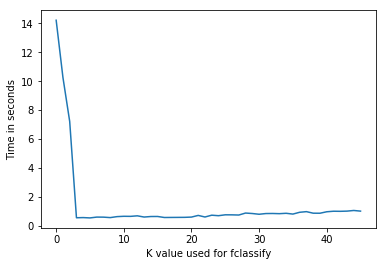

In [63]:
import matplotlib.pyplot as plt
plt.plot(time_taken_Knn_with_fclassify)
plt.ylabel('Time in seconds')
plt.xlabel('K value used for fclassify')
plt.show()

The above results shows that we get the best result for k=1

# Feature Reduction using chi2

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


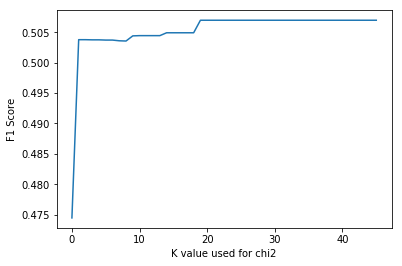

Best F1 Score is 0.506979555373
Best k (Number of features) is 20


In [64]:
# Using Select k best with chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import time
time_taken_Knn_with_chi2 = []
f1_score_Knn_with_chi2 = []
for i in range(1,47):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=81, n_jobs=-1)
    model = SelectKBest(chi2, k = i)
    model.fit(X_train, y_train)
    X_train_with_dr = model.transform(X_train)
    X_test_with_dr =  model.transform(X_test)
    #   Transform train and test data after DR
    neigh.fit(X_train_with_dr, y_train)
    predicted = neigh.predict(X_test_with_dr)
    f1_score_Knn_with_chi2.append(metrics.f1_score(y_test, predicted, average='weighted'))
    elapsed_time = time.time() - start_time
    time_taken_Knn_with_chi2.append(elapsed_time)

import matplotlib.pyplot as plt
plt.plot(f1_score_Knn_with_chi2)
plt.ylabel('F1 Score')
plt.xlabel('K value used for chi2')

plt.show()
best_f1 = max(f1_score_Knn_with_chi2)
print("Best F1 Score is " + str(best_f1))
print("Best k (Number of features) is "+ str(f1_score_Knn_with_chi2.index(best_f1)+1))



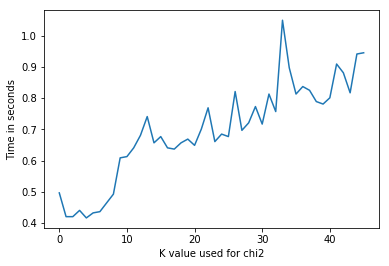

In [65]:
import matplotlib.pyplot as plt
plt.plot(time_taken_Knn_with_chi2)
plt.ylabel('Time in seconds')
plt.xlabel('K value used for chi2')
plt.show()

# Comparing performance of selectKbest

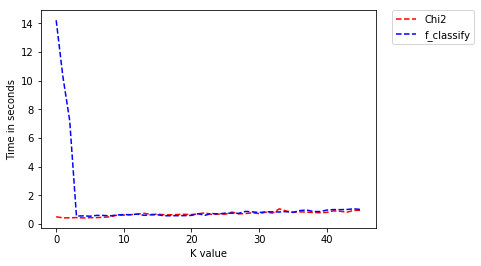

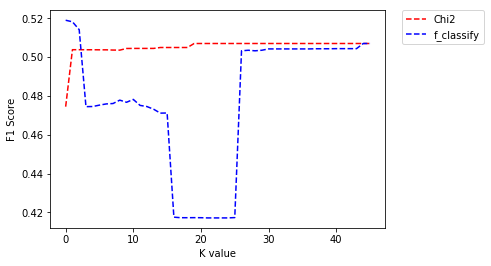

In [150]:
plt.xlabel('K value')
plt.ylabel('Time in seconds')
plt.plot(time_taken_Knn_with_chi2,'r--', label = "Chi2")
plt.plot(time_taken_Knn_with_fclassify,'b--', label = "f_classify")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


plt.xlabel('K value')
plt.ylabel('F1 Score')
plt.plot(f1_score_Knn_with_chi2,'r--', label = "Chi2")
plt.plot(f1_score_Knn_with_fcassify,'b--', label = "f_classify")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# L1-based feature selection

In [67]:
# Using SelectFromModel L1-based feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import time
f1_score_Knn_with_LinearSVC = []
time_taken_Knn_with_LinearSVC = []

start_time = time.time()
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)
print(X_train_with_dr.shape)
#   Transform train and test data after DR
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)
f1_score_Knn_with_LinearSVC.append(metrics.f1_score(y_test, predicted, average='weighted'))
#     print(f1_score_Knn_without_preprocessing[i-1])
elapsed_time = time.time() - start_time
time_taken_Knn_with_LinearSVC.append(elapsed_time)

start_time = time.time()
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)
print(X_train_with_dr.shape)
#   Transform train and test data after DR
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)
f1_score_Knn_with_LinearSVC.append(metrics.f1_score(y_test, predicted, average='weighted'))
#     print(f1_score_Knn_without_preprocessing[i-1])
elapsed_time = time.time() - start_time
time_taken_Knn_with_LinearSVC.append(elapsed_time)

start_time = time.time()
lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)
print(X_train_with_dr.shape)
#   Transform train and test data after DR
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)
f1_score_Knn_with_LinearSVC.append(metrics.f1_score(y_test, predicted, average='weighted'))
#     print(f1_score_Knn_without_preprocessing[i-1])
elapsed_time = time.time() - start_time
time_taken_Knn_with_LinearSVC.append(elapsed_time)

start_time = time.time()
lsvc = LinearSVC(C=10, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)
print(X_train_with_dr.shape)

#   Transform train and test data after DR
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)
f1_score_Knn_with_LinearSVC.append(metrics.f1_score(y_test, predicted, average='weighted'))
#     print(f1_score_Knn_without_preprocessing[i-1])
elapsed_time = time.time() - start_time
time_taken_Knn_with_LinearSVC.append(elapsed_time)

start_time = time.time()
lsvc = LinearSVC(C=100, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)

#   Transform train and test data after DR
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)
f1_score_Knn_with_LinearSVC.append(metrics.f1_score(y_test, predicted, average='weighted'))
#     print(f1_score_Knn_without_preprocessing[i-1])
elapsed_time = time.time() - start_time
time_taken_Knn_with_LinearSVC.append(elapsed_time)




(81412, 37)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(81412, 40)
(81412, 45)
(81412, 46)


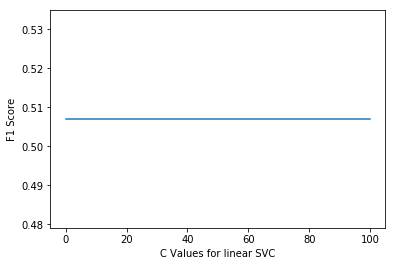

Best F1 Score is 0.506979555373
Best C Value is 1


In [68]:
import matplotlib.pyplot as plt
y = [0.01, 0.1, 1, 10, 100]
plt.plot(y, f1_score_Knn_with_LinearSVC)
plt.ylabel('F1 Score')
plt.xlabel('C Values for linear SVC')

plt.show()
best_f1 = max(f1_score_Knn_with_LinearSVC)
print("Best F1 Score is " + str(best_f1))
print("Best C Value is "+ str(f1_score_Knn_with_LinearSVC.index(best_f1)+1))

In [69]:
print(f1_score_Knn_with_LinearSVC)

[0.50697955537274775, 0.50697955537274775, 0.50697955537274775, 0.50697955537274775, 0.50697955537274775]


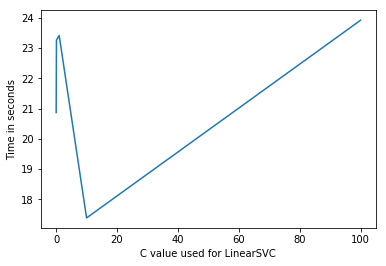

In [70]:
import matplotlib.pyplot as plt
plt.plot(y, time_taken_Knn_with_LinearSVC)
plt.ylabel('Time in seconds')
plt.xlabel('C value used for LinearSVC')
plt.show()

In [71]:
print(time_taken_Knn_with_LinearSVC)
print(y)

[20.8675434589386, 23.26205539703369, 23.411197662353516, 17.389100551605225, 23.915858030319214]
[0.01, 0.1, 1, 10, 100]


# Tree based feature selection

In [72]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)

model = SelectFromModel(clf, prefit=True)
X_train_with_dr = model.transform(X_train)
X_test_with_dr = model.transform(X_test)
print(X_train_with_dr.shape)
neigh.fit(X_train_with_dr, y_train)
predicted = neigh.predict(X_test_with_dr)

print(metrics.f1_score(y_test, predicted, average='weighted'))

(81412, 21)
0.506979555373


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
# Using various K values for the best DR Parameter set

In [82]:
f1sc=[]
tim=[]
for i in range(1,100):
    start_time = time.time()
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    X_train_with_dr = SelectKBest(f_classif, k = 1).fit_transform(X_train, y_train)
    X_test_with_dr = SelectKBest(f_classif, k = 1).fit_transform(X_test, y_test)
    #   Transform train and test data after DR
    neigh.fit(X_train_with_dr, y_train)
    predicted = neigh.predict(X_test_with_dr)
    f1sc.append(metrics.f1_score(y_test, predicted, average='weighted'))
    elapsed_time = time.time() - start_time
    tim.append(elapsed_time)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [39 40] are constant.
  UserWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [29 37 39 40 44 45 46] are constant.
  UserWarning)


9.41654348373413


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


14.130872011184692
14.118807315826416
9.544715881347656
10.465763807296753
10.35782504081726
14.19891881942749
9.73322582244873
9.668878316879272
9.4951491355896
9.599207878112793
14.454974174499512
14.383163928985596
14.158857822418213
18.427655935287476
21.93777108192444
9.503150939941406
9.586365938186646
9.664137363433838
14.494890928268433
14.632915735244751
9.694827556610107
14.390197038650513
9.67124629020691
9.776313304901123
14.206713438034058
9.708269596099854
9.538115978240967
14.226940870285034
14.364229679107666
9.597559213638306
9.605526208877563
9.540242195129395
9.752912044525146
14.52771544456482
14.315061807632446
10.248110055923462
9.878341436386108
14.397761106491089
10.189943790435791
9.903393268585205
9.72185230255127
9.809672117233276
14.450267553329468
9.44213080406189
9.821665525436401
9.98954176902771
14.484713077545166
10.056773662567139
9.718646764755249
14.680445432662964
15.127888917922974
9.90235710144043
14.46247673034668
9.592788696289062
14.06681919097

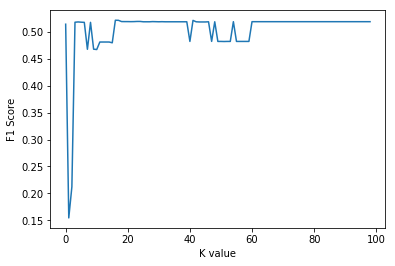

Best F1 Score is 0.521631765422
Best k (Number of features) is 17


In [83]:
import matplotlib.pyplot as plt
plt.plot(f1sc)
plt.ylabel('F1 Score')
plt.xlabel('K value')

plt.show()
best_f1 = max(f1sc)
print("Best F1 Score is " + str(best_f1))
print("Best k (Number of features) is "+ str(f1sc.index(best_f1)+1))


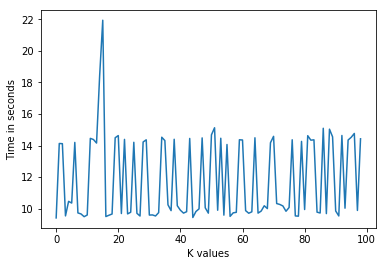

In [84]:
import matplotlib.pyplot as plt
plt.plot(tim)
plt.ylabel('Time in seconds')
plt.xlabel('K values')
plt.show()

In [149]:
sum(tim)/60

19.54274592002233